# Fitting a 1D function

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch

import pyqtorch.modules as pyq

Let's define a target function we want to fit.

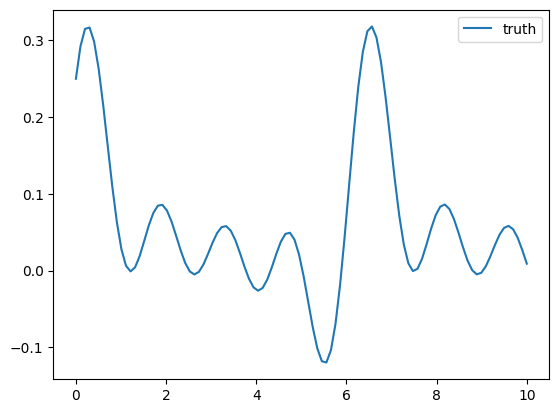

In [2]:

def target_function(x, degree=3):
    result = 0
    for i in range(degree):
        result += torch.cos(i*x) + torch.sin(i*x)
    return .05 * result

x = torch.tensor(np.linspace(0, 10, 100))
target_y = target_function(x, 5)

plt.plot(x.numpy(), target_y.numpy(), label="truth")
plt.legend()
plt.show()

To fit this function with a QNN we need an entangling ansatz. We will use a layer of `U`-gates and a layer of `CNOT`s:

In [3]:
def ULayerAnsatz(n_qubits, n_layers):
    ops = []
    for _ in range(n_layers):
        ops.append(pyq.VariationalLayer(n_qubits, pyq.U))
        ops.append(pyq.EntanglingLayer(n_qubits))
    return pyq.QuantumCircuit(n_qubits, ops)

ULayerAnsatz(3,1)

QuantumCircuit(
  (operations): ModuleList(
    (0): VariationalLayer(
      (operations): ModuleList(
        (0): U(qubits=[0], n_qubits=3)
        (1): U(qubits=[1], n_qubits=3)
        (2): U(qubits=[2], n_qubits=3)
      )
    )
    (1): EntanglingLayer(
      (operations): ModuleList(
        (0): CNOT(qubits=[0, 1], n_qubits=3)
        (1): CNOT(qubits=[1, 2], n_qubits=3)
        (2): CNOT(qubits=[2, 0], n_qubits=3)
      )
    )
  )
)

We can define a QNN by implementing a custom `torch.nn.Module`.

In [4]:
class Model(torch.nn.Module):

    def __init__(self, n_qubits, n_layers):
        super().__init__()
        self.n_qubits = n_qubits
        self.ansatz1 = ULayerAnsatz(n_qubits, n_layers)
        self.embedding = pyq.FeaturemapLayer(n_qubits, pyq.RX)
        self.ansatz2 = ULayerAnsatz(n_qubits, n_layers)
        self.observable = pyq.Z([0], n_qubits)
        
    def forward(self, x):
        batch_size = len(x)
        state = self.ansatz1.init_state(batch_size)
        
        state = self.ansatz1(state)
        state = self.embedding(state, x)
        state = self.ansatz2(state)
        
        new_state = self.observable(state)
        
        state = state.reshape((2**self.n_qubits, batch_size))
        new_state = new_state.reshape((2**self.n_qubits, batch_size))
        return torch.real(torch.sum(torch.conj(state) * new_state, axis=0))

Let's verify that we are getting reasonable outputs from our untrained QNN

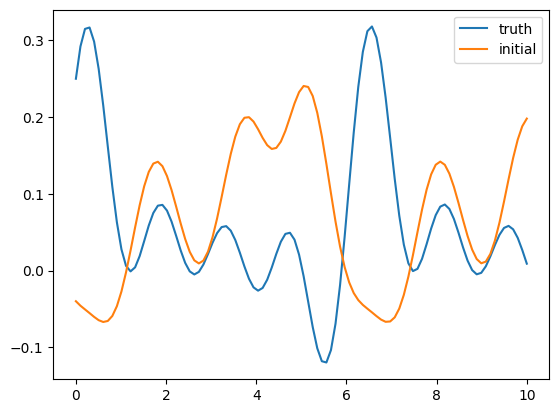

In [5]:
n_qubits = 5
n_layers = 3
model = Model(n_qubits, n_layers)

with torch.no_grad():
    y = model(x)

plt.plot(x.numpy(), target_y.numpy(), label="truth")
plt.plot(x.numpy(), y.numpy(), label="initial")
plt.legend()
plt.show()

Our QNN is implemented as a `torch.nn.Module` so we can use the usual `torch` optimizers to train it.

In [7]:
import torch.nn.functional as F

optimizer = torch.optim.Adam(model.parameters(), lr=.01)
epochs = 200

for epoch in range(epochs):
    optimizer.zero_grad()
    y_pred = model(x)
    loss = F.mse_loss(target_y, y_pred)
    loss.backward()
    optimizer.step()
    print(f"Epoch {epoch+1:03d} | Loss {loss}")

Epoch 001 | Loss 1.181170973931877e-05
Epoch 002 | Loss 3.9005150204328295e-05
Epoch 003 | Loss 0.0005210030244242805
Epoch 004 | Loss 6.012409726695054e-05
Epoch 005 | Loss 0.00021009194032554318
Epoch 006 | Loss 0.0002914833038541067
Epoch 007 | Loss 0.0001454984851627904
Epoch 008 | Loss 4.142681408782311e-05
Epoch 009 | Loss 9.054882419142336e-05
Epoch 010 | Loss 0.0001531790494452143
Epoch 011 | Loss 0.00012015653011887463
Epoch 012 | Loss 5.790713974401939e-05
Epoch 013 | Loss 3.846728702473956e-05
Epoch 014 | Loss 5.630471569536954e-05
Epoch 015 | Loss 7.700979061854381e-05
Epoch 016 | Loss 7.391532378356758e-05
Epoch 017 | Loss 4.612078963466576e-05
Epoch 018 | Loss 2.155939995688723e-05
Epoch 019 | Loss 2.3721610576853985e-05
Epoch 020 | Loss 4.3170004830746536e-05
Epoch 021 | Loss 5.069962559255113e-05
Epoch 022 | Loss 3.5152058993235534e-05
Epoch 023 | Loss 1.4055374744605247e-05
Epoch 024 | Loss 1.023692829664193e-05
Epoch 025 | Loss 2.4446698606623847e-05
Epoch 026 | Loss 

We can verify that the final prediction looks like the target function:

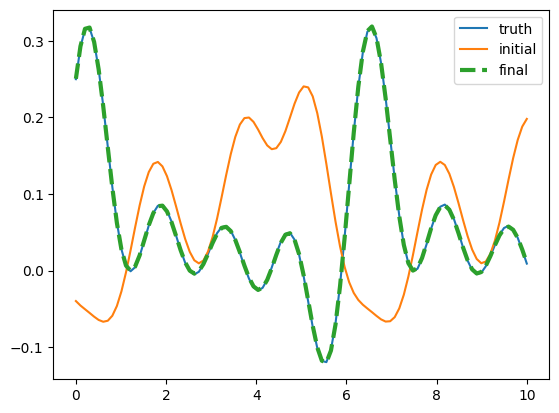

In [13]:
with torch.no_grad():
    y_final = model(x)

plt.plot(x.numpy(), target_y.numpy(), label="truth")
plt.plot(x.numpy(), y.numpy(), label="initial")
plt.plot(x.numpy(), y_final.numpy(), "--", label="final", linewidth=3)
plt.legend()
plt.show()